<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/RNNConsumoDeAgua.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/archive.zip

unzip:  cannot find or open /content/archive.zip, /content/archive.zip.zip or /content/archive.zip.ZIP.


In [21]:
from pandas import read_csv
from datetime import datetime
import pandas as pd
from matplotlib import pyplot
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error


print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


**LECTURA DE DATOS**

In [22]:
#LOADING DATA 
df= read_csv('/content/AguaH.csv')
df = df.iloc[0:1000 , :]
#AJUSTE DEL FORMATO DE LAS FECHAS PARA LA TRANSFORMACION A TIPO DATETIME
lookup = {'ENE':'01','FEB':'02','MAR':'03','ABR':'04','MAY':'05','JUN':'06','JUL':'07','AGO':'08','SEP':'09','OCT':'10','NOV':'11','DIC':'12'}
clist=[]
for col in df.columns[5:]:
    col = col[4:].split('_')
    clist.append('20'+col[1]+'-'+lookup[col[0]]+'-01')

columns = ['LANDUSE_TYPE','USER','PIPE DIAM','VENDOR','JAN16']+clist
df.columns=columns
df = df.drop(columns=['LANDUSE_TYPE','PIPE DIAM','VENDOR','JAN16'])

#df=df.transpose()
print("Dataframe shape ",df.shape)


Dataframe shape  (1000, 85)


In [23]:
rows_list=[]
dataComp = pd.DataFrame(columns=('DATE','TIPO', 'CONSUMO'))
for column in range(1,len(df.columns),1):
  selection=df.iloc[:,column]
  for row in range(len(selection)):
    df2=[df.columns[column],df.iloc[row,0],selection.iloc[row]]
    rows_list.append(df2)
    
dataComp = pd.DataFrame(rows_list)  

In [24]:
dataComp.rename(columns = {0:'DATE',1:'TIPO',2:'CONSUMO'}, inplace = True)
dataComp['DATE'] = pd.to_datetime(dataComp['DATE'], format='%Y-%m-%d')
dataComp=dataComp.set_index('DATE')

In [26]:
dataComp.index.min()

Timestamp('2009-01-01 00:00:00')

In [28]:
print(len(dataComp['2009']))
print(len(dataComp['2010']))
print(len(dataComp['2011']))
print(len(dataComp['2012']))
print(len(dataComp['2013']))
print(len(dataComp['2014']))
print(len(dataComp['2015']))

12000
12000
12000
12000
12000
12000
12000


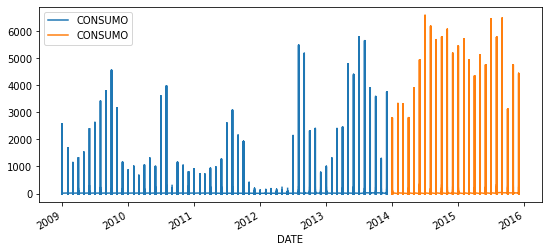

In [38]:
import matplotlib.pyplot as plt
steps = 24000
datos_train = dataComp[:-steps]
datos_test  = dataComp[-steps:]
fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [ ]:
#ESTE CODIGO SIRVE UNICAMENTE PARA LA INTEGRACION DE LOS NOMBRES EN EL DATAFRAME
col_list = ["Name"]
names = pd.read_csv("/content/StateNames.csv", usecols=col_list)
names = names.iloc[0:84000 , :]
#ELIMINAMOS LA COLUMNA DE LOS NOMBRE YA QUE SE BINARIZARON
#df = df.iloc[: , 1:]
print("Names shape ",names.shape)

Names shape  (84000, 1)


In [ ]:
dataComp.insert(loc=1, column='Names', value=names)


In [ ]:
#RELLENANDO VALORES NAN POR LA MEDIA
dataComp=dataComp.fillna(dataComp['CONSUMO'].mean())
#CONVIRTIENDO EL INDICE DEL DATAFRAME EN TIPO DATETIME
#dataComp.index = pd.to_datetime(dataComp.index)
#type(dataComp.index)

In [ ]:
#APLICANDO ONE HOT ENCODER A LA COLUMNA DEL TIPO DE CONSUMO
one_hot = pd.get_dummies(dataComp['TIPO'])
dataComp = dataComp.drop('TIPO',axis = 1)
dataComp = dataComp.join(one_hot)


In [ ]:
#APLICANDO ONE HOT ENCODER A LA COLUMNA DEL TIPO DE NOMBRES
one_hot_names = pd.get_dummies(dataComp['Names'])
dataComp = dataComp.drop('Names',axis = 1)
dataComp = dataComp.join(one_hot_names)

In [ ]:
dataComp.head()

,DATE,CONSUMO,COMERCIAL,DOMESTICO BAJA,DOMESTICO MEDIO,DOMESTICO RESIDENCIAL,ESPECIAL,INDUSTRIAL,SOCIAL,Aaliyah,Aaron,Abagail,Abbey,Abbie,Abbigail,Abbigayle,Abby,Abel,Abigail,Abigayle,Abraham,Ada,Adalyn,Adalynn,Adam,Addie,Addison,Adelaide,Adele,Adelia,Adeline,Adell,Adella,Adelle,Adelynn,Aden,Adria,Adrian,Adriana,Adriane,...,Yulonda,Yvetta,Yvette,Yvonne,Zachariah,Zachary,Zachery,Zackary,Zackery,Zada,Zadie,Zakiya,Zana,Zander,Zandra,Zane,Zaneta,Zaria,Zariah,Zayden,Zelda,Zella,Zelma,Zena,Zenobia,Zenovia,Zeola,Zera,Zettie,Zhane,Zina,Zion,Zoe,Zoey,Zoie,Zola,Zona,Zora,Zula,Zykeria
0,2009-01-01,20.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009-01-01,26.140072,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2009-01-01,26.140072,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2009-01-01,26.140072,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2009-01-01,20.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
values = dataComp.iloc[:,1:].values
train, test=train_test_split(values,test_size=.2,shuffle=False)
# asegurarse que todo esta en formato float
values = values.astype('float32')
# normalzación
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.00304136, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00397507, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00397507, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00243309, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00060827, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00425791, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:

numregistros=scaled.shape[0]
print(numregistros)
# split en conjuntos de train y test
n_train = int(round(numregistros*0.8,0)) #80% para entrenamiento 67200
print(n_train)
train = values[:n_train, :]
test = values[n_train:, :]

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :], train[:, -1]

In [ ]:
print(pd.DataFrame(train_X))

            0     1     2     3     4     ...  4038  4039  4040  4041  4042
0      20.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
1      26.140072   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2      26.140072   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
3      26.140072   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
4      20.000000   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
67195  20.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67196  32.000000   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
67197  10.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67198   0.000000   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67199  36.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[67200 rows x 4043 columns]


In [ ]:
print(pd.DataFrame(train_y))

         0
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
...    ...
67195  0.0
67196  0.0
67197  0.0
67198  0.0
67199  0.0

[67200 rows x 1 columns]


In [ ]:

test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# LSTSM ESPERA [muestras, paso del tiempo,caracteristicas]

84000
67200
(67200, 1, 4043) (67200,) (16800, 1, 4042) (16800,)


In [ ]:
print(pd.DataFrame(train))
print(train.shape)

            0     1     2     3     4     ...  4038  4039  4040  4041  4042
0      20.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
1      26.140072   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
2      26.140072   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
3      26.140072   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
4      20.000000   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
...          ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
67195  20.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67196  32.000000   0.0   0.0   0.0   1.0  ...   0.0   0.0   0.0   0.0   0.0
67197  10.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67198   0.000000   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0
67199  36.000000   0.0   0.0   1.0   0.0  ...   0.0   0.0   0.0   0.0   0.0

[67200 rows x 4043 columns]
(67200, 4043)


In [ ]:
test.shape

(16800, 4043)

Epoch 1/100
934/934 - 15s - loss: 0.0123 - val_loss: 0.0095 - 15s/epoch - 16ms/step
Epoch 2/100
934/934 - 12s - loss: 0.0081 - val_loss: 0.0095 - 12s/epoch - 13ms/step
Epoch 3/100
934/934 - 12s - loss: 0.0082 - val_loss: 0.0102 - 12s/epoch - 13ms/step
Epoch 4/100
934/934 - 12s - loss: 0.0074 - val_loss: 0.0091 - 12s/epoch - 12ms/step
Epoch 5/100
934/934 - 12s - loss: 0.0079 - val_loss: 0.0090 - 12s/epoch - 12ms/step
Epoch 6/100
934/934 - 12s - loss: 0.0071 - val_loss: 0.0090 - 12s/epoch - 12ms/step
Epoch 7/100
934/934 - 11s - loss: 0.0070 - val_loss: 0.0088 - 11s/epoch - 12ms/step
Epoch 8/100
934/934 - 11s - loss: 0.0068 - val_loss: 0.0088 - 11s/epoch - 12ms/step
Epoch 9/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0086 - 11s/epoch - 12ms/step
Epoch 10/100
934/934 - 12s - loss: 0.0067 - val_loss: 0.0086 - 12s/epoch - 12ms/step
Epoch 11/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0085 - 11s/epoch - 12ms/step
Epoch 12/100
934/934 - 11s - loss: 0.0067 - val_loss: 0.0086 - 11s/epoch -

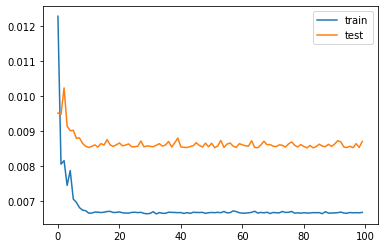

In [ ]:
# Diseño de la red recurrente LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(128))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                1051648   
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,060,097
Trainable params: 1,060,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred= model.predict(test_X)


In [ ]:
pd.DataFrame(test_y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4003,4004,4005,4006,4007,4008,4009,4010,4011,4012,4013,4014,4015,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034,4035,4036,4037,4038,4039,4040,4041,4042
0,22.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,28.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16796,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16797,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16798,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_pred.shape

(16800, 1)

(16800, 4043)

In [ ]:
tes

In [ ]:
mean_squared_error(test_y, y_pred, squared=False)

In [ ]:
 # serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 

Saved model to disk
Loaded model from disk


In [ ]:
#FUNCION PARA ESCOGER UN REGISTRO DENTRO DEL DATAFRAME PARA LAS PRUEBAS DE VALIDACION
def selectRabbit(user):
  xnew = dataComp.iloc[user , 1:999]
  return xnew


In [ ]:
#FUNCION PARA BUSCAR EL VALOR REAL DE CONSUMO DENTRO DEL DATAFRAME
def searchForReal(user):
  real= dataComp.iloc[user ,-1]
  return real

In [ ]:
user=dataComp.iloc[-1,1:]

In [ ]:
user.shape

(4043,)

In [ ]:
def prediccion(user):
    Xnew = np.array([dataComp.iloc[-1,1:]])#real es 79
    print(Xnew.shape)
    #xnew=selectRabbit(user)
    Xnew= scaler.transform(Xnew)
    Xnew = Xnew.reshape((Xnew.shape[0], 1, Xnew.shape[1]))
    print(Xnew.shape)
    pred= model.predict(Xnew)[0]
    return pred
    
pred=prediccion(83)
print('PREDICCION DE CONSUMO: ',pred)
#print('USUARIO CONSUMO REAL :  [',searchForReal(83),']')

(1, 4043)
(1, 1, 4043)


ValueError: ignored